By starting from a subset of data from the OECD: https://data.oecd.org/agroutput/crop-production.htm the aim is to answer three questions:
1. Can we identify the BRICS countries only by looking at their crops?
2. If a country is productive in one crop, does it tend to be productive in some other crop?
3. If a country is productive in one year, does it tend to be productive in some other year?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_validate, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam

from scipy.stats import beta
from imblearn.over_sampling import SMOTE

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

Using TensorFlow backend.


In [2]:
df = pd.read_csv('OECD_Crop_Yield_Data.csv')
df.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,CROPYIELD,RICE,TONNE_HA,A,1990,5.374114,NaN
1,AUS,CROPYIELD,RICE,TONNE_HA,A,1991,5.374114,NaN
2,AUS,CROPYIELD,RICE,TONNE_HA,A,1992,5.897753,NaN
3,AUS,CROPYIELD,RICE,TONNE_HA,A,1993,5.903150,NaN
4,AUS,CROPYIELD,RICE,TONNE_HA,A,1994,5.221311,NaN


In [3]:
# No uppercase columns please
df = df.rename({col:col.lower() for col in df}, axis=1)

# Exploratory Data Analysis

In [4]:
df.shape

(4022, 8)

In [5]:
df.isnull().mean()

location      0.0
indicator     0.0
subject       0.0
measure       0.0
frequency     0.0
time          0.0
value         0.0
flag codes    1.0
dtype: float64

In [6]:
df.nunique()

location        37
indicator        1
subject          4
measure          1
frequency        1
time            29
value         3416
flag codes       0
dtype: int64

In [7]:
# Let's remove the variables that don't add new information
df = df[[var for var in df if df[var].nunique() > 1]]
df.head()

,location,subject,time,value
0,AUS,RICE,1990,5.374114
1,AUS,RICE,1991,5.374114
2,AUS,RICE,1992,5.897753
3,AUS,RICE,1993,5.903150
4,AUS,RICE,1994,5.221311


In [8]:
# Countries and groups of countries in the data
df['location'].unique()

array(['AUS', 'CAN', 'JPN', 'KOR', 'MEX', 'NZL', 'TUR', 'USA', 'ARG',
       'BRA', 'CHL', 'CHN', 'COL', 'EGY', 'ETH', 'IND', 'IDN', 'IRN',
       'KAZ', 'MYS', 'NGA', 'PAK', 'PRY', 'PHL', 'RUS', 'SAU', 'ZAF',
       'THA', 'UKR', 'VNM', 'WLD', 'OECD', 'BRICS', 'NOR', 'CHE', 'EU28',
       'ISR'], dtype=object)

In [9]:
# Types of crops in the data
df['subject'].unique()

array(['RICE', 'WHEAT', 'MAIZE', 'SOYBEAN'], dtype=object)

In [10]:
# No uppercase crops...
df['subject'] = df['subject'].apply(lambda x: x.title())

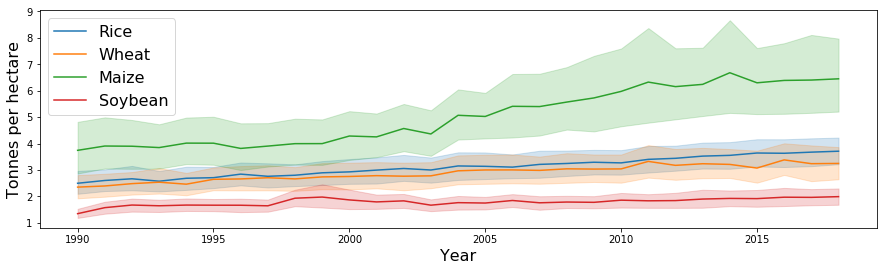

In [12]:
# Overview of production against time per crop
plt.figure(figsize=(15,4))
for s in df['subject'].unique():
    sns.lineplot(x='time', y='value', data=df[df['subject']==s], label=s)
plt.ylabel('Tonnes per hectare', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.legend(fontsize=16)
#plt.savefig('graphs/tonnes.png', transparent=True)
plt.show()

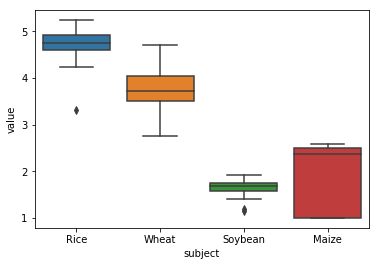

In [13]:
# Same but without time
mask = df['location'] == 'JPN'
sns.boxplot(x='subject', y='value', data=df[mask])
plt.show()

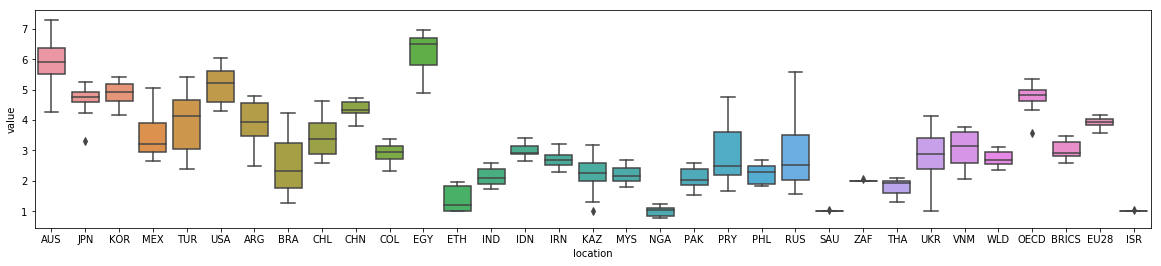

In [14]:
# Separated by location
mask = df['subject'] == 'Rice'
plt.figure(figsize=(20,4))
sns.boxplot(x='location', y='value', data=df[mask])
plt.show()

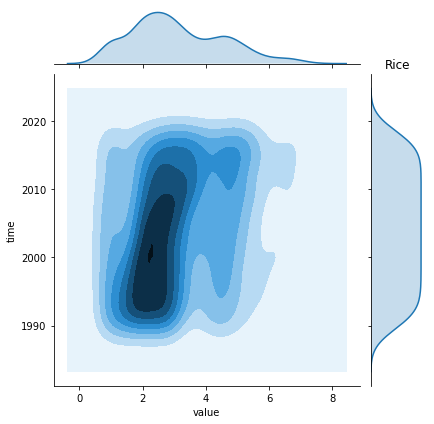

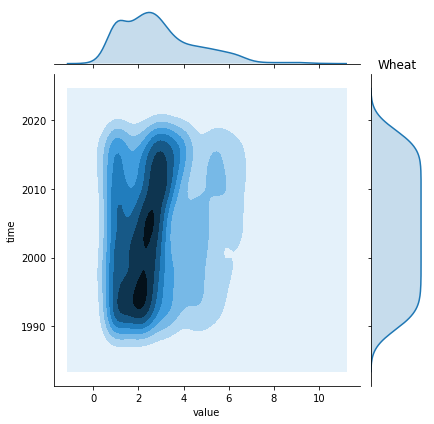

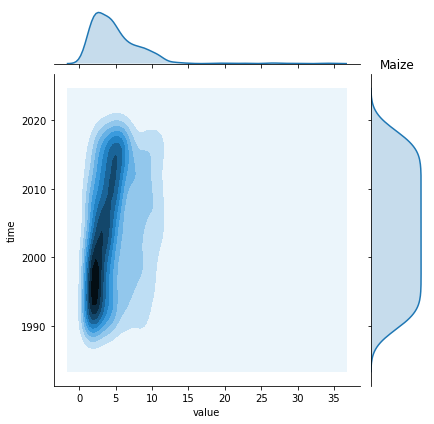

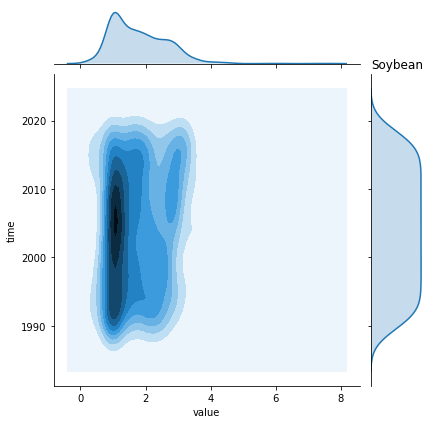

In [15]:
# Try some KDE
for crop in df['subject'].unique():
    mask = df['subject']==crop
    sns.jointplot(x=df['value'][mask], y=df['time'][mask], kind='kde')
    plt.title(crop)
    plt.show()

# Identifying whether a country is BRICS or not

BRICS is the acronym coined for an association of five major emerging national economies: Brazil, Russia, India, China and South Africa

In [16]:
# Get the data in the right shape, with each crop as a variable
df = df.pivot_table(index=['location', 'time'], columns='subject').reset_index()
crops = ['maize', 'rice', 'soy', 'wheat']
df.columns = ['location', 'time'] + crops
df.fillna(0, inplace=True)

In [17]:
df.shape

(1069, 6)

In [18]:
# It is necessary to take out BRICS and OECD because these contain duplicated countries
brics = ['BRA', 'CHN', 'IND', 'RUS', 'SAU']
groups = ['BRICS', 'OECD']

df['brics'] = df['location'].apply(lambda x: x in brics)
no_groups_mask = df['location'].apply(lambda x: x not in groups)
dfng = df.loc[no_groups_mask].copy()

In [19]:
# A naive approach of always predicting "No BRICS" will have over 86% accuracy
1 - df.brics.mean()

0.8643592142188962

### Trying to separate BRICS countries graphically

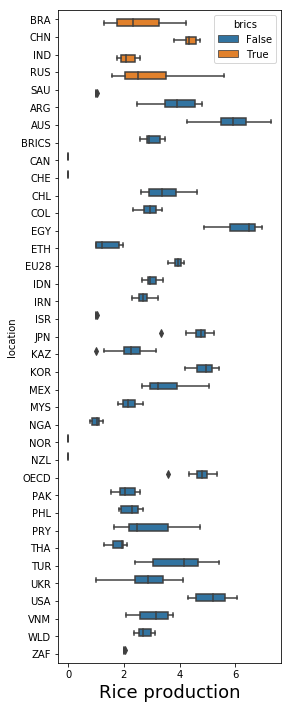

In [20]:
order = brics + [x for x in df['location'].unique() if x not in brics]
plt.figure(figsize=(4,12))
sns.boxplot(y='location', x='rice', data=df, hue='brics',
           order=order)
plt.xlabel('Rice production', fontsize=18)
plt.show()

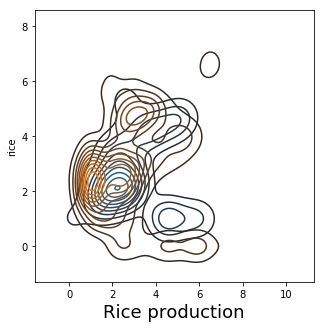

In [21]:
plt.figure(figsize=(5,5))
sns.kdeplot(df[df['brics']]['wheat'], df[df['brics']]['rice'])
sns.kdeplot(df[~df['brics']]['wheat'], df[~df['brics']]['rice'])
plt.xlabel('Rice production', fontsize=18)
plt.show()

In [22]:
dfng.shape

(1011, 7)

In [23]:
dfng.head()

,location,time,maize,rice,soy,wheat,brics
0,ARG,1990,3.461538,2.487521,2.421053,1.897370,False
1,ARG,1991,4.044737,2.751163,2.291329,2.180807,False
2,ARG,1992,4.524736,3.534752,2.158913,2.327357,False
3,ARG,1993,4.355174,2.952857,2.038261,2.023904,False
4,ARG,1994,4.237219,2.930496,2.044313,2.167205,False


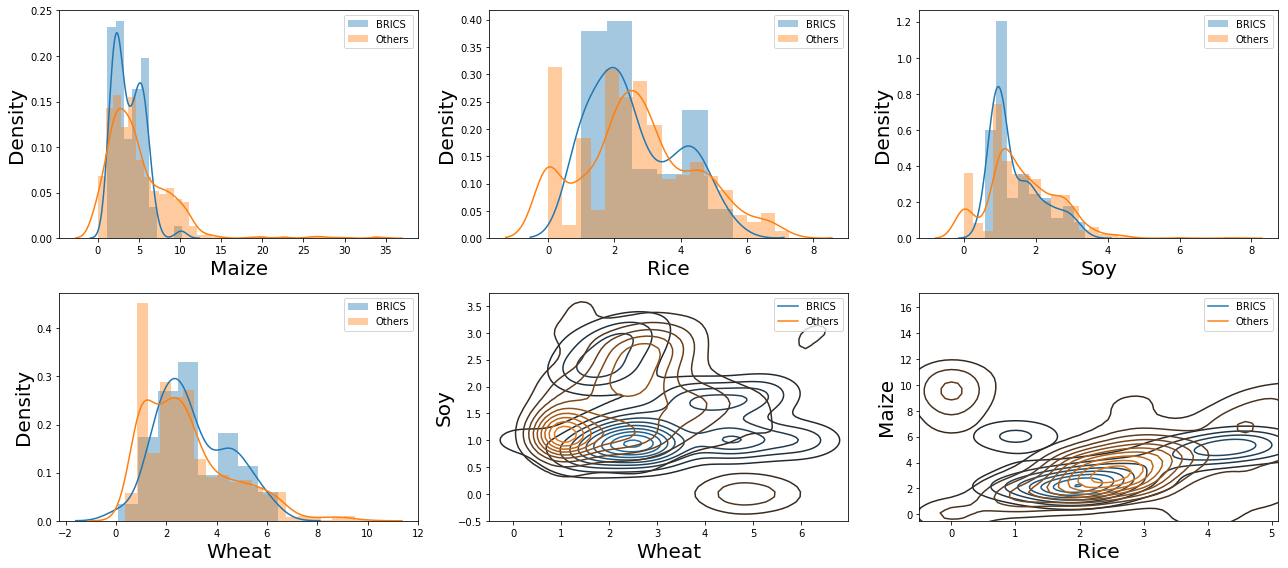

In [25]:
plt.figure(figsize=(18,8))
for i, cr in enumerate(crops):
    plt.subplot(2, 3, i+1)
    sns.distplot(dfng[cr][dfng['brics']], label='BRICS')
    sns.distplot(dfng[cr][~dfng['brics']], label='Others')
    plt.legend()
    plt.xlabel(cr.title(), fontsize=20)
    plt.ylabel('Density', fontsize=20)
for i, c in enumerate((('wheat', 'soy'), ('rice', 'maize'))):
    plt.subplot(2, 3, i+5)
    sns.kdeplot(df[df['brics']][c[0]], df[df['brics']][c[1]], label='BRICS')
    sns.kdeplot(df[~df['brics']][c[0]], df[~df['brics']][c[1]], label='Others')
    plt.xlabel(c[0].title(), fontsize=20)
    plt.ylabel(c[1].title(), fontsize=20)
    plt.legend()
    plt.xlim((-0.5, df[c[0]].max() * 0.7))
    plt.ylim((-0.5, df[c[1]].max() * 0.5))
plt.tight_layout()
#plt.savefig('graphs/distributions.png')
plt.show()

### Moving on to supervised learning

In [26]:
def time_split(df, time, n=5, df_test=None):
    '''Receives a dataframe df and yields train and test index'''
    if df_test is None:
        df_test = df
    
    time_min = df[time].min()
    interval = (df[time].max() - time_min) / (n+1)
    
    for i in range(1, n+1):
        train_offset = time_min + interval * i
        train_mask = df[time] <= train_offset
        test_offset = time_min + interval * (i + 1)
        test_mask = np.logical_and(df_test[time]>=train_offset, df_test[time]<=test_offset)
        yield train_mask, test_mask

In [27]:
def time_cv(model, df, X, y, time, n=5, df_test=None, 
            scorers=[accuracy_score, f1_score, confusion_matrix], **kwargs):
    '''Receives a model and some data, performs time series cross validation on
       panel data and returns a list of lists with all the scores obtained'''
    score = [[] for _ in scorers]
    if df_test is None:
        df_test = df
    
    for train, test in time_split(df, time, n, df_test):
        model.fit(df.loc[train, X], df.loc[train, y], **kwargs)
        preds = model.predict(df_test.loc[test, X]).round(0)
        
        for i in range(len(scorers)):
            score[i].append(scorers[i](df_test.loc[test, y], preds))
            
    return score

In [28]:
def time_search_cv(model, param_grid, df, X, y, time, n=5, df_test=None, scorer=f1_score, verbose=True):
    '''Performs parameter gridsearch with time series cross validation on panel data'''
    param_grid = ParameterGrid(param_grid)
    best_score = -np.inf
    best_params = {}
    for params in param_grid:
        model.set_params(**params)
        score = np.mean(time_cv(model, df, X, y, time, n, df_test, [scorer]))
        if score > best_score:
            best_score = score
            best_params = params
    if verbose:
        print('Best score:', best_score, '\nBest params:', best_params)
    return best_params

In [29]:
def print_scores(scores, names=['Accuracy', 'F1', 'Confusion matrix']):
    '''Helper function to print scores'''
    for i, n in enumerate(names):
        std = np.std(scores[i], axis=0).round(2)
        mean = np.mean(scores[i], axis=0).round(3)
        print('{}: {} ({})'.format(n, mean, std))

In [30]:
# A first approach to handle umbalanced data is by undersampling it
nbrics = dfng['brics'].sum()
print(nbrics)
usdf = dfng[~dfng['brics']].sample(nbrics)
usdf = usdf.append(dfng[dfng['brics']])
print(usdf.shape)

145
(290, 7)


In [31]:
# But we may also oversample (resample) it
sm = SMOTE()
x_res, y_res = sm.fit_resample(dfng[crops+['time']], dfng['brics'])
resdf = pd.DataFrame(x_res, columns=crops+['time'])
resdf['brics'] = y_res
resdf['time'] = resdf['time'].round(0).astype(int)

In [32]:
%%time
# Fit a preliminary random forest to test that everything is working correctly
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
params = {'max_depth':[None, 2, 5, 10], 'min_impurity_decrease':[0.0, 0.01, 0.1]}
time_search_cv(rf, params, usdf, crops, 'brics', 'time', df_test=dfng)

Best score: 0.49102070453065105 
Best params: {'max_depth': None, 'min_impurity_decrease': 0.0}
Wall time: 25.5 s


In [33]:
%%time
# Set the classifiers and implement them
rf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
rf_params = {'max_depth':[None, 2, 5, 10], 'min_impurity_decrease':[0.0, 0.01, 0.1]}

xgb = XGBClassifier(n_estimators=200, n_jobs=-1)
xgb_params = {'max_depth':[3, 5], 'learning_rate':[0.1, 0.01], 'gamma':[0, 0.01]}

svc = SVC()
svc_params = {'C':[1.0, 2.0, 1.5, 0.5], 'gamma':['scale', 'auto']}

estimators = (('Random Forest', rf, rf_params), 
              ('XGBoost', xgb, xgb_params), 
              ('SVM', svc, svc_params))
for name, estimator, params in estimators:
    print('*--'*20)
    print(name)
    params = time_search_cv(estimator, params, dfng, crops, 'brics', 'time', verbose=False)
    estimator.set_params(**params)
    print('\nOriginal')
    print_scores(time_cv(estimator, dfng, crops, 'brics', 'time'))
    print('\nUndersampled')
    print_scores(time_cv(estimator, usdf, crops, 'brics', 'time', df_test=dfng))
    print('\nOversampled')
    print_scores(time_cv(estimator, resdf, crops, 'brics', 'time', df_test=dfng))

*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
Random Forest

Original
Accuracy: 0.907 (0.02)
F1: 0.561 (0.13)
Confusion matrix: [[148.2   1.8]
 [ 14.4  10.6]] ([[1.6 1.6]
 [2.8 2.8]])

Undersampled
Accuracy: 0.819 (0.06)
F1: 0.501 (0.1)
Confusion matrix: [[127.8  22.2]
 [  9.4  15.6]] ([[12.75 12.75]
 [ 4.22  4.22]])

Oversampled
Accuracy: 0.895 (0.03)
F1: 0.577 (0.16)
Confusion matrix: [[143.4   6.6]
 [ 11.8  13.2]] ([[2.8  2.8 ]
 [4.58 4.58]])
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
XGBoost

Original
Accuracy: 0.897 (0.02)
F1: 0.537 (0.15)
Confusion matrix: [[146.   4.]
 [ 14.  11.]] ([[1.55 1.55]
 [3.85 3.85]])

Undersampled
Accuracy: 0.797 (0.08)
F1: 0.483 (0.1)
Confusion matrix: [[123.6  26.4]
 [  9.2  15.8]] ([[16.16 16.16]
 [ 3.49  3.49]])

Oversampled
Accuracy: 0.88 (0.03)
F1: 0.556 (0.14)
Confusion matrix: [[140.2   9.8]
 [ 11.2  13.8]] ([[1.72 1.72]
 [4.53 4.53]])
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
SVM

Original
Ac

In [34]:
# Create an MLP
model = Sequential()
model.add(Dense(100, input_shape=(4,)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               500       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               20100     
__________

In [35]:
%%time
# Train and test the MLP with the original data
print_scores(time_cv(model, dfng, crops, 'brics', 'time', 
                     batch_size=512, epochs=200, verbose=0, validation_split=0.2))

Accuracy: 0.874 (0.02)
F1: 0.603 (0.03)
Confusion matrix: [[136.2  13.8]
 [  8.2  16.8]] ([[6.88 6.88]
 [3.12 3.12]])
Wall time: 18.1 s


In [36]:
%%time
# Train and test the MLP with the undersampled
print_scores(time_cv(model, usdf, crops, 'brics', 'time', df_test=dfng,
                     batch_size=512, epochs=200, verbose=0, validation_split=0.2))

Accuracy: 0.914 (0.01)
F1: 0.675 (0.05)
Confusion matrix: [[144.   6.]
 [  9.  16.]] ([[3.85 3.85]
 [3.41 3.41]])
Wall time: 5.83 s


In [37]:
%%time
# Train and test the MLP with the oversampled
print_scores(time_cv(model, resdf, crops, 'brics', 'time', df_test=dfng,
                     batch_size=512, epochs=200, verbose=0, validation_split=0.2))

Accuracy: 0.923 (0.01)
F1: 0.713 (0.07)
Confusion matrix: [[144.4   5.6]
 [  7.8  17.2]] ([[2.87 2.87]
 [3.25 3.25]])
Wall time: 10.1 s


In summary, although accuracy is good, F1 score only gets up to 71% with MLP, which is a good result so we may identify BRICS countries from their crops.

# If a country is productive in one crop, does it tend to be productive in some other crop?

### Defining productivity
A country will only be considered as productive if it produces at least 90% of the equitative contribution rate

In [38]:
total_countries = dfng['location'].nunique()
equitative_production = 100/total_countries
equitative_productions = np.array([equitative_production for i in range(total_countries+1)])
almost = 0.9
for cr in crops:
    total_production = dfng.groupby(['time'])[cr].sum()
    contributions = dfng[cr] / dfng['time'].map(total_production) *100
    dfng[cr+'_contributions'] = contributions
    dfng[cr+'_productive'] = (contributions > equitative_production * almost).astype(int)

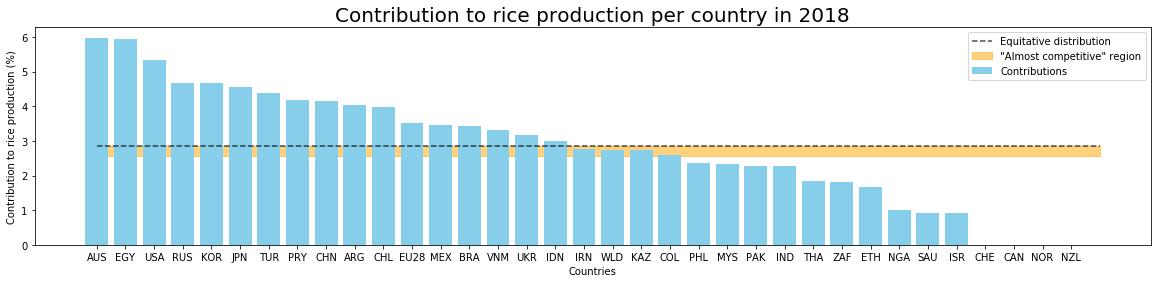

In [40]:
data = dfng[dfng['time']==2018].sort_values('rice', ascending=False)
plt.figure(figsize=(20,4))
plt.bar(data.location, data.rice_contributions, label='Contributions', color='skyblue')
plt.hlines(equitative_production, 0, total_countries, linestyles='--', alpha=0.7, label='Equitative distribution')
plt.fill_between(range(0, total_countries+1), equitative_productions, equitative_productions*almost, color='orange', 
                 alpha=0.5, label='"Almost competitive" region')
plt.xlabel('Countries')
plt.ylabel('Contribution to rice production (%)')
plt.title('Contribution to rice production per country in 2018', fontsize=20)
plt.legend()
#plt.savefig('graphs/productive_countries.png')
plt.show()

In [41]:
dfng.head()

,location,time,maize,rice,soy,wheat,brics,maize_contributions,maize_productive,rice_contributions,rice_productive,soy_contributions,soy_productive,wheat_contributions,wheat_productive
0,ARG,1990,3.461538,2.487521,2.421053,1.897370,False,2.844392,1,3.413366,1,6.019234,1,2.377312,0
1,ARG,1991,4.044737,2.751163,2.291329,2.180807,False,3.166548,1,3.602904,1,4.624443,1,2.672151,1
2,ARG,1992,4.524736,3.534752,2.158913,2.327357,False,3.584609,1,4.521156,1,4.086929,1,2.755450,1
3,ARG,1993,4.355174,2.952857,2.038261,2.023904,False,3.431592,1,3.878691,1,3.923521,1,2.323531,0
4,ARG,1994,4.237219,2.930496,2.044313,2.167205,False,3.250927,1,3.605042,1,3.902784,1,2.529378,0


### Bayesian inference
Assuming that these target proportions may be modelled with beta distributions and using uninformative prior.

In [42]:
# Calculate the number of products that a country is competitive in
dfng['nprod'] = dfng.filter(regex='.+_productive').sum(axis=1)

In [43]:
print('Competitive: {:.2f}, More than 1: {:.2f}'.format((dfng['nprod'] > 0).mean(), (dfng['nprod'] > 1).mean()))

Competitive: 0.85, More than 1: 0.59


In [44]:
def draw_beta(a, b, show=True, title=None, linewidth=2):
    '''Helper function for drawing a beta distribution'''
    # Add uninformative prior
    a += 1
    b += 1
    
    # Get beta and plot it
    x = np.linspace(beta.ppf(0, a, b), beta.ppf(1, a, b), 1000)
    y = beta.pdf(x, a, b)
    plt.plot(x, y, alpha=0.6, label='beta pdf', linewidth=linewidth)
    plt.xlim(0, 1)
    plt.ylabel('Density')
    plt.xlabel('PDF')
    if title is not None:
        plt.title(title, fontsize=18)
    if show:
        plt.show()

In [45]:
(dfng['nprod'] > 1).sum() / (dfng['nprod'] >= 1).sum()

0.6939252336448598

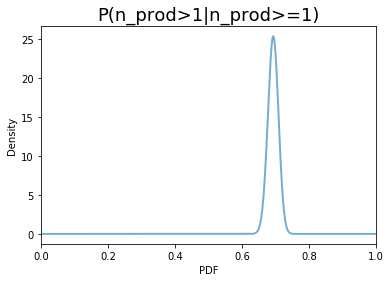

In [46]:
# Probability of n_prod>1 given that n_prod>=1
a = (dfng['nprod'] > 1).sum()
b = (dfng['nprod'] == 1).sum()
draw_beta(a, b, title='P(n_prod>1|n_prod>=1)')

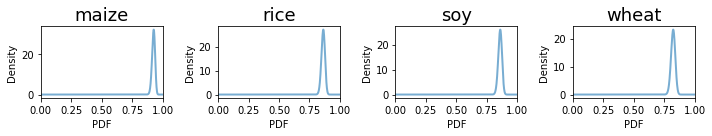

In [47]:
# Probability of n_prod>1 given that {crop}_productive==1
plt.figure(figsize=(10,2))
for i, cr in enumerate(crops):
    a = (np.logical_and(dfng['nprod'] > 1, dfng[f'{cr}_productive'] == 1)).sum()
    b = (np.logical_and(dfng['nprod'] == 1, dfng[f'{cr}_productive'] == 1)).sum()
    plt.subplot(1, 4, i+1)
    draw_beta(a, b, False, cr)
plt.tight_layout()
plt.show()

### Dimmensionality reduction
By assessing the possibility of representing the data in lower dimmensions we may understand some of its structure.

In [48]:
# As the data have different means and variances, scaling is necessary
scaler = StandardScaler()
scaled_crops = scaler.fit_transform(dfng[crops])

In [49]:
pca = PCA()
pca.fit(scaled_crops)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

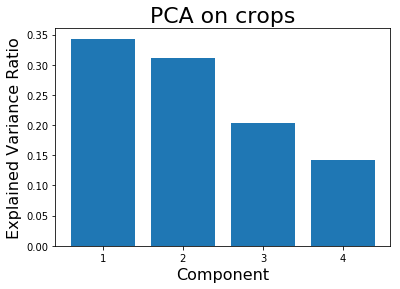

In [50]:
plt.bar([str(i) for i in range(1,5)], pca.explained_variance_ratio_)
plt.xlabel('Component', fontsize=16)
plt.ylabel('Explained Variance Ratio', fontsize=16)
plt.title('PCA on crops', fontsize=22)
#plt.savefig('graphs/pca_crop.png', transparent=True)
plt.show()

In [51]:
pca.components_

array([[ 0.49723814,  0.54733692,  0.61687665,  0.26951758],
       [ 0.5094576 , -0.3813674 , -0.36837796,  0.67772379],
       [ 0.48270259, -0.61128757,  0.3734315 , -0.50385973],
       [ 0.51010332,  0.4258036 , -0.58677916, -0.46279165]])

In [52]:
pca.singular_values_

array([37.24798626, 35.47315489, 28.73488268, 23.92800282])

There is no linear dependence among crops. Thus, if a country is competitive in one crop, it does not tend to be productive in another.

### Modelling

In [53]:
# Prepare the data for modelling
# Add constant to make it explicit
dfng['c'] = 1

# Add interations among variables
for i in range(2,5):
    for comb in combinations(crops, i):
        name = '_'.join(list(comb)) + '_productive'
        dfng[name] = 1
        for var in comb:
            dfng[name] *= dfng[f'{var}_productive']

# Add the productivity in t-1
dfng.sort_values(['location', 'time'], inplace=True)
dfng['nprod_last_year'] = dfng.groupby(['location'])['nprod'].shift(1)
for cr in crops:
    dfng[f'{cr}_last_year'] = dfng.groupby(['location'])[f'{cr}_productive'].shift(1)

In [54]:
# Fit a Logistic Regression with L1 regularization (CV alpha selection) model and print coefficients
# No last year information
for cr in crops:
    logic = LogisticRegressionCV(cv=5, fit_intercept=False, penalty='l1', solver='liblinear')
    X = list(dfng.filter(regex='^((?!{}).)*_productive$'.format(cr)).columns) + ['c']
    logic.fit(dfng[X], dfng[f'{cr}_productive'])
    print(f'{cr} model:')
    coef = logic.coef_[0]
    print({i: j for i, j in zip(X, coef) if j != 0})
    print('*--'*20)
    print('')

maize model:
{'rice_productive': 0.26599042238186915, 'soy_productive': 0.2557820730174665, 'wheat_productive': 1.10921962031486, 'rice_soy_productive': 1.2694552919112039, 'rice_wheat_productive': 0.09833444733077086, 'soy_wheat_productive': 1.5422358212622458, 'rice_soy_wheat_productive': -2.1662677863306983, 'c': -1.578203322964924}
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--

rice model:
{'soy_productive': 0.6551055009579143, 'maize_soy_productive': 0.34920495897227105, 'soy_wheat_productive': 0.21797144846629177, 'c': -0.2394120214911259}
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--

soy model:
{'maize_productive': 0.1657741022882883, 'rice_productive': 0.5806349770420584, 'maize_rice_productive': 0.6458009583024017, 'c': -0.4535643073412273}
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--

wheat model:
{'maize_productive': 0.6521937233139466, 'c': -0.27282834835699366}
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--



In [55]:
# Fit a Logistic Regression with L1 regularization (CV alpha selection) model and print coefficients
# Include last year information
for cr in crops:
    logic = LogisticRegressionCV(cv=5, fit_intercept=False, penalty='l1', solver='liblinear')
    X = list(dfng.filter(regex='^((?!{}).)*_productive$'.format(cr)).columns) + ['c', f'{cr}_last_year']
    logic.fit(dfng.dropna()[X], dfng.dropna()[f'{cr}_productive'])
    print(f'{cr} model:')
    coef = logic.coef_[0]
    print({i: j for i, j in zip(X, coef) if j != 0})
    print('*--'*20)

maize model:
{'c': -1.9505286182902255, 'maize_last_year': 4.05982403508914}
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
rice model:
{'rice_last_year': 0.5816171874747}
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
soy model:
{'maize_rice_productive': 0.08610192336064532, 'c': -1.3883880982087229, 'soy_last_year': 3.1986116299590557}
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
wheat model:
{'c': -1.4813415316950107, 'wheat_last_year': 3.1934967826312874}
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--


In [56]:
# Add dummies for location
wddf = dfng.merge(pd.get_dummies(dfng['location']), left_index=True, right_index=True)
wddf.drop(['location', 'time', 'nprod', 'brics', 'nprod_last_year'], axis=1, inplace=True)
wddf.drop(wddf.filter(regex='.*contributions').columns, axis=1, inplace=True)

In [57]:
# Fit a Logistic Regression with L1 regularization (CV alpha selection) model and print coefficients
# Include last year information and location
for cr in crops:
    logic = LogisticRegressionCV(cv=5, fit_intercept=False, penalty='l1', solver='liblinear')
    X = list(wddf.filter(regex='^((?!{}).)+$'.format(cr)).columns) + [f'{cr}_last_year']
    logic.fit(wddf.dropna()[X], wddf.dropna()[f'{cr}_productive'])
    print(f'{cr} model:')
    coef = logic.coef_[0]
    print({i: j for i, j in zip(X, coef) if j != 0})
    print('*--'*20)

maize model:
{'rice': -0.014493331842821524, 'c': -1.9151406728351243, 'maize_last_year': 4.06959826415855}
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
rice model:
{'maize': -0.04345115961206013, 'wheat': -0.055460274881727556, 'c': -1.4582842685035733, 'rice_last_year': 4.291621198691714}
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
soy model:
{'maize': -0.013684073699371318, 'rice': 0.03353266435121257, 'wheat': -0.061649344159042385, 'c': -1.23367926776857, 'maize_rice_productive': 0.08938323747096542, 'soy_last_year': 3.1894083315025568}
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--
wheat model:
{'rice': -0.015852783388515507, 'soy': -0.1759411318774837, 'c': -1.1504522972960776, 'wheat_last_year': 3.1944045786887325}
*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--*--


# If a country is productive in one year, does it tend to be productive in some other year?

### Bayesian inference
Assuming that these target proportions may be modelled with beta distributions and using uninformative prior.

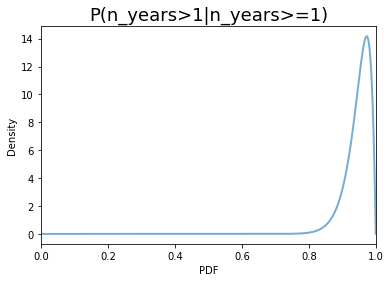

In [58]:
# Probability of time_product>1 given that time_product>=1
time_product = (dfng.pivot_table(index='location', columns='time', values='nprod') > 0).sum(axis=1)
a = (time_product > 1).sum() + 1
b = (time_product == 1).sum() + 1
draw_beta(a, b, title='P(n_years>1|n_years>=1)')

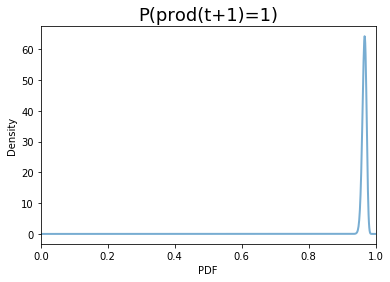

In [59]:
# If you were productive this year, will you be productive next year?
productive = dfng[['nprod', 'nprod_last_year']].dropna()
mask_posi = np.logical_and(productive['nprod'] > 0, productive['nprod_last_year'] > 0)
mask_nega = np.logical_and(productive['nprod'] == 0, productive['nprod_last_year'] > 0)
a = mask_posi.sum()
b = mask_nega.sum()
draw_beta(a, b, title='P(prod(t+1)=1)')

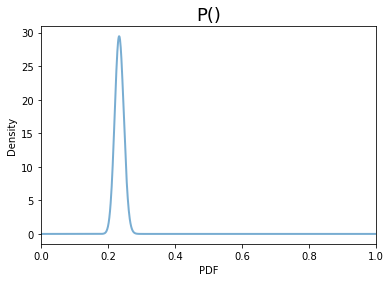

In [60]:
# Will your productivity change next year?
mask = productive['nprod'] == productive['nprod_last_year']
a = (~mask).sum()
b = mask.sum()
draw_beta(a, b, title='P()')

In [61]:
productive = productive.apply(lambda x: x.apply(lambda y: 1 if y>0 else 0))
productive['c'] = 1
logic.fit(productive[['c', 'nprod_last_year']], productive['nprod'])
logic.coef_

array([[0.        , 1.18230792]])

### PCA

In [62]:
mdf = dfng.melt(id_vars=['location', 'time'], value_vars=['maize', 'rice', 'soy', 'wheat'], var_name='crop')
mdf = mdf.pivot_table(index=['location', 'crop'], columns='time', values='value')
mdf = scaler.fit_transform(mdf.fillna(0))

In [63]:
pca.fit(mdf)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

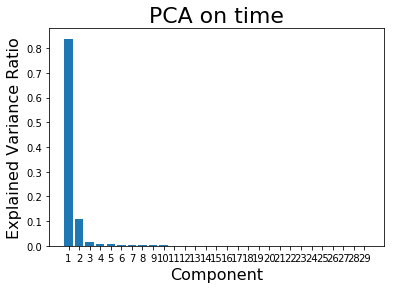

In [64]:
plt.bar([str(i) for i in range(1,30)], pca.explained_variance_ratio_)
plt.xlabel('Component', fontsize=16)
plt.ylabel('Explained Variance Ratio', fontsize=16)
plt.title('PCA on time', fontsize=22)
#plt.savefig('graphs/pca_time.png', transparent=True)
plt.show()

In [65]:
pca.components_[0]

array([0.18807718, 0.19245574, 0.19248191, 0.1921532 , 0.19694655,
       0.19605669, 0.1732323 , 0.17281203, 0.17282913, 0.16938062,
       0.16984646, 0.17507355, 0.17200676, 0.17228028, 0.19837782,
       0.19141816, 0.19602073, 0.19684952, 0.19752908, 0.18928768,
       0.18683348, 0.18097071, 0.18931979, 0.19272296, 0.1825044 ,
       0.18927447, 0.18436246, 0.18159365, 0.18556704])

The first component has abount an equal contribution for each year, so we have a highly correlated figure, supporting that if a country is competitive in a year, the it will be competitive in some other years aswell.

# Reprinting some figures in a presentation friendly format

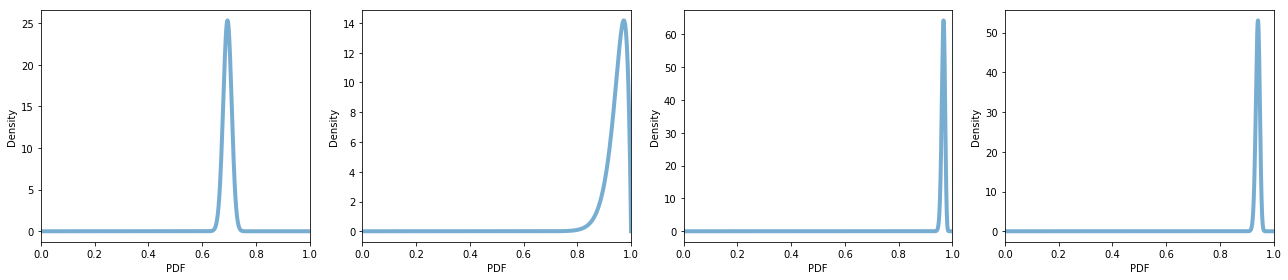

In [66]:
plt.figure(figsize=(18,4))
plt.subplot(1, 4, 1)
# Probability of n_prod>1 given that n_prod>=1
a = (dfng['nprod'] > 1).sum()
b = (dfng['nprod'] == 1).sum()
draw_beta(a, b, False, linewidth=4)
# Time
plt.subplot(1, 4, 2)
a = (time_product > 1).sum() + 1
b = (time_product == 1).sum() + 1
draw_beta(a, b, False, linewidth=4)
# Next year
plt.subplot(1, 4, 3)
a = mask_posi.sum()
b = mask_nega.sum()
draw_beta(a, b, False, linewidth=4)
# Change
plt.subplot(1, 4, 4)
mask = productive['nprod'] == productive['nprod_last_year']
a = (mask).sum()
b = (~mask).sum()
draw_beta(a, b, False, linewidth=4)

plt.tight_layout()
#plt.savefig('graphs/allbetas.png', transparent=True)
plt.show()